In [1]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torchvision._utils as util
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
import pandas as pd
import cv2 as cv
import os
import sklearn.model_selection as sc
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


In [2]:
x_train = []
y_train = []

folder_path = "/Users/bhara-zstch1566/CNN/Project/My data model/Dataset"

for foldername in os.listdir(folder_path):
    if foldername==".DS_Store":
        continue
    inside = (folder_path+"/"+foldername)
    for filename in os.listdir(inside):
        if filename==".DS_Store":
            continue

        img =cv.imread(inside+'/'+filename) 
        x_train.append(img)
        y_train.append((foldername))


In [3]:
label = np.unique(y_train).sort()

lab = sorted(list(set(y_train)),key=lambda x:x.upper())
mapping = {}
for ind,i in enumerate(lab):
    mapping[i]=ind+1
lab


['A', 'B', 'C', 'L', 'Nothing', 'O', 'V', 'W', 'Z']

In [4]:
for i in range(len(y_train)):
    y_train[i]=mapping[y_train[i]]

In [5]:
set(y_train)

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
dataset = {"image":[],"label":[]}

In [7]:
for i in range(len(y_train)):
    dataset['image'].append(x_train[i])
    dataset["label"].append(y_train[i])


In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def preprocess(example):
    example["image"] = [transform(img) for img in example["image"]]
    return example

dataset = preprocess(dataset)

In [9]:
x_train,x_dev,y_train,y_dev = sc.train_test_split(dataset['image'],dataset['label'],test_size=0.30,random_state=42,shuffle=True)

In [10]:
y_train,y_dev = t.tensor(y_train),t.tensor(y_dev)

In [11]:
x_train,x_dev = t.stack(x_train),t.stack(x_dev)

In [12]:
x_train.shape

torch.Size([3021, 3, 64, 64])

In [13]:
x_test,x_dev,y_test,y_dev = sc.train_test_split(x_dev,y_dev,test_size=0.50,random_state=42,shuffle=True)

In [14]:

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

dev_dataset = TensorDataset(x_dev, y_dev)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(x_test,y_test)
test_loader = DataLoader(test_dataset,batch_size=64, shuffle=False)

In [ ]:


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out
    
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []

        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [16]:
model = ResNet(ResidualBlock, [2, 2, 2, 2], 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

In [17]:
device = "mps" if t.mps.is_available() else "cpu"
device

'mps'

Epoch [1/5], Loss: 0.1713, Dev Accuracy: 99.85%
Epoch [2/5], Loss: 0.0053, Dev Accuracy: 99.85%
Epoch [3/5], Loss: 0.0274, Dev Accuracy: 99.23%
Epoch [4/5], Loss: 0.1029, Dev Accuracy: 99.54%
Epoch [5/5], Loss: 0.0115, Dev Accuracy: 100.00%
Epoch [6/5], Loss: 0.0011, Dev Accuracy: 100.00%
Epoch [7/5], Loss: 0.0003, Dev Accuracy: 100.00%
Epoch [8/5], Loss: 0.0002, Dev Accuracy: 100.00%
Epoch [9/5], Loss: 0.0002, Dev Accuracy: 100.00%
Epoch [10/5], Loss: 0.0006, Dev Accuracy: 100.00%
Epoch [11/5], Loss: 0.0015, Dev Accuracy: 99.85%
Epoch [12/5], Loss: 0.0017, Dev Accuracy: 100.00%
Epoch [13/5], Loss: 0.0003, Dev Accuracy: 100.00%
Epoch [14/5], Loss: 0.0002, Dev Accuracy: 100.00%
Epoch [15/5], Loss: 0.0001, Dev Accuracy: 100.00%


<Axes: >

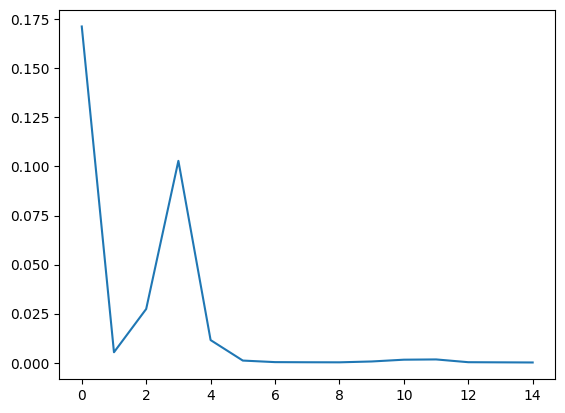

In [18]:
epochs = 15
device = "mps" if t.mps.is_available() else "cpu"
model = model.to(device)
cost = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    cnt = 0
    for x, y in train_loader:         
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    cost.append(running_loss / len(train_loader))

    correct = 0
    total = 0
    with t.no_grad():
        for x,y in dev_loader:

            x, y = x.to(device), y.to(device)
            
            outputs = model(x)
            _, predicted = t.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    print(f"Epoch [{epoch+1}/{5}], Loss: {running_loss / len(train_loader):.4f}, Dev Accuracy: {100*correct/total:.2f}%")
sns.lineplot(cost)

In [19]:

correct = 0
total = 0
with t.no_grad():
    for x,y in test_loader:
        
        x, y = x.to(device), y.to(device)
        
        outputs = model(x)
        _, predicted = t.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")

Test Accuracy: 100.00%


In [20]:
480*9*0.7

3024.0

In [21]:
x_train.shape

torch.Size([3021, 3, 64, 64])

In [22]:
x_dev.shape

torch.Size([648, 3, 64, 64])

In [23]:
y_dev.shape

torch.Size([648])

In [24]:
y_train.shape

torch.Size([3021])

In [25]:
t.save(model.state_dict(), "model.pth")

In [27]:
import cv2
import os

output_folder = "Test"
frame_width = 200
frame_height = 200
fps = 2
duration_sec = 1

os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Cannot open camera")
    exit()

total_frames = fps * duration_sec
frame_count = 0

print("Recording video...")

while frame_count < total_frames:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    
    frame_resized = cv2.resize(frame, (frame_width, frame_height))
    
    frame_filename = os.path.join(output_folder, f"frame_{frame_count:03d}.jpg")
    cv2.imwrite(frame_filename, frame_resized)
    
    frame_count += 1
    
    cv2.waitKey(int(1000 / fps))

print(f"Saved {frame_count} frames to '{output_folder}'")

cap.release()
cv2.destroyAllWindows()



with t.no_grad():
    cnt = 0
    for x in os.listdir("/Users/bhara-zstch1566/CNN/Project/My data model/model/Test"):
        img = cv.imread("/Users/bhara-zstch1566/CNN/Project/My data model/model/Test/"+x)
        if not cnt:
            cnt+=1
            continue

        transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

        x = transform(img).unsqueeze(0).to(device)  
        outputs = model(x)
        _, predicted = t.max(outputs.data, 1)

        print(f"Predicted : {lab[predicted.item()-1]}")

lis =  os.listdir("/Users/bhara-zstch1566/CNN/Project/My data model/model/Test")
for i in lis:
    os.remove("/Users/bhara-zstch1566/CNN/Project/My data model/model/Test/"+i)


Recording video...
Saved 2 frames to 'Test'
Predicted : O
